# Using a Variational autoencoder to generate digit examples

This script demonstrates how to build a variational autoencoder with Keras.

Opposed to a deterministic AE, that learns a hierarchical deterministic reconstruction function which goes through a bottleneck layer defining the latent space, a VAE learns the parameters of a probability distribution for the latent space used to model your data. We can sample points from this distribution to generate new samples: a VAE is a "generative model".

For computational reasons we work with the MNIST data and a simple VAE to check if the latent space representations  is suitable reveal 10 different patterns in the data and for generating new digits.

Reference: 
Code is adapted from https://blog.keras.io/building-autoencoders-in-keras.html
Some theory on "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

In [2]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


### Define the architecture of the VAE:

In [3]:
# defining the parameteres
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 20
epsilon_std = 1.0

In [4]:
# defining the encoder
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

We use the reparametrization trick to avoid stochastic nodes in backpropagation nodes.

In [5]:
# defining a function to add random noise to the latent representation z_mean and z_log_var
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# the Lambda() function wraps an arbitrary expression as a Layer object
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In the encoder we have learned parameters which then are used to sample new similar points from the latent space. The decoder gets "a sampled z realization" as input.

In [6]:
# defining the decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

The loss function encourages a good reconstruction and discourages a deviation of the learned latent z distribution from the N(0,1) distribution.

In [7]:
# defining our own loss with the usual crossentropy and the penalty for Kullback–Leibler 
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [8]:
# build a model to reconstruct the input
vae = Model(inputs=x, outputs=x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [9]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# we will only use 20k digits for the traning, to speed up computing time
x_train=x_train[0:20000]

In [10]:
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (100, 784)            0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (100, 256)            200960                                       
____________________________________________________________________________________________________
dense_2 (Dense)                  (100, 2)              514                                          
____________________________________________________________________________________________________
dense_3 (Dense)                  (100, 2)              514                                          
___________________________________________________________________________________________

In [11]:
# training the vae
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),verbose=2)

Train on 20000 samples, validate on 10000 samples
Epoch 1/20
24s - loss: 219.1790 - val_loss: 183.4232
Epoch 2/20
22s - loss: 180.1899 - val_loss: 176.8163
Epoch 3/20
22s - loss: 175.1561 - val_loss: 174.3815
Epoch 4/20
22s - loss: 172.7668 - val_loss: 171.4854
Epoch 5/20
24s - loss: 171.3698 - val_loss: 170.1602
Epoch 6/20
25s - loss: 170.2410 - val_loss: 170.3510
Epoch 7/20
26s - loss: 169.3506 - val_loss: 169.7797
Epoch 8/20
26s - loss: 168.4782 - val_loss: 168.8334
Epoch 9/20
27s - loss: 167.9256 - val_loss: 167.5565
Epoch 10/20
27s - loss: 167.3659 - val_loss: 168.1205
Epoch 11/20
26s - loss: 166.9657 - val_loss: 167.9314
Epoch 12/20
27s - loss: 166.6836 - val_loss: 167.6002
Epoch 13/20
26s - loss: 166.5292 - val_loss: 165.2833
Epoch 14/20
27s - loss: 166.4712 - val_loss: 166.7690
Epoch 15/20
27s - loss: 166.4914 - val_loss: 169.0566
Epoch 16/20
26s - loss: 166.7840 - val_loss: 172.5387
Epoch 17/20
27s - loss: 167.1030 - val_loss: 164.9982
Epoch 18/20
26s - loss: 167.4386 - val_lo

Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

In [12]:
# build a model to project inputs on the latent space
encoder = Model(inputs=x, outputs=z_mean)

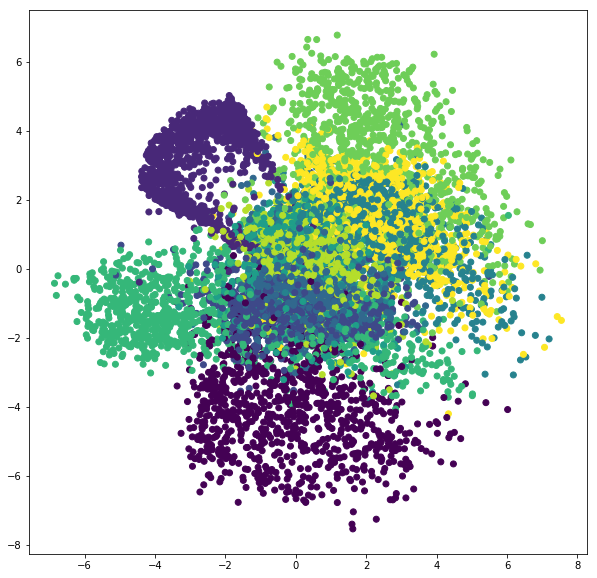

In [13]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)

In [14]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(inputs=decoder_input, outputs= _x_decoded_mean)

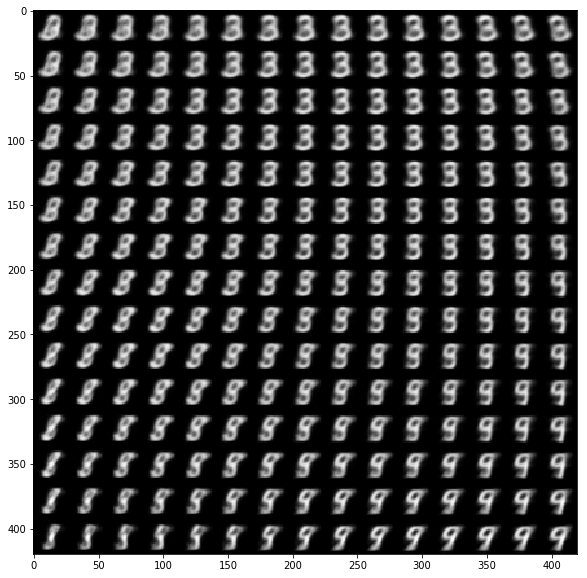

In [15]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we want to use the 5%, 10%, 15%, ... 95% quantiles of the N(0,1) 
# (which we get by linearly spaced coordinates on the unit square that were transformed through the 
# inverse CDF (ppf) of the standard Gaussian, since the prior of the latent space is Gaussian)
# to scan the space of the latent variables z
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

If you use the whole MNIST dataset for the trainig and train for 50 epochs the result of the generator looks like this: 
![](https://www.dropbox.com/s/qq6mkbgvm262evg/VAE_output.png?dl=1)
